In [55]:
import logging
logging.basicConfig(level=logging.CRITICAL)

import os
import json
import hoomd
import codecs
import cooltools

import numpy as np
import matplotlib as mpl
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)
import matplotlib.pyplot as plt

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render
import polychrom_hoomd.extrude as extrude

from polykit.analysis import polymer_analyses, contact_maps
from polykit.analysis.polymer_analyses import Rg2
from polykit.generators.initial_conformations import grow_cubic

import gsd
import numpy as np
import pandas as pd
import time
from polychrom_hoomd.utils import unwrap_coordinates

In [2]:
device = hoomd.device.GPU(notice_level=3, gpu_ids=[1])

In [16]:
def simulate(number_of_iterations=2e5, 
             density=0.2, 
             chromosome_sizes=[15000], 
             dpd=False, 
             contact_list=[], 
             spherical=False,
             starting_conformation=None
            ):

    number_of_monomers = sum(chromosome_sizes)
    confinement_radius = (3*number_of_monomers / (4*np.pi*density))**(1/3.)
    
    rng_seed = os.urandom(2)
    rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)
    system = hoomd.Simulation(device=device, seed=rng_seed)

    number_of_monomers = sum(chromosome_sizes)
    L = (number_of_monomers/density) ** (1/3.)
    
    # Build random, dense initial conformations
    if spherical:
        inscribed_cube_length = confinement_radius*2/3**.5
        snapshot = build.get_simulation_box(box_length=2*L)
        if starting_conformation is None:
            monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(inscribed_cube_length))
        else:
            monomer_positions = starting_conformation
    else:
        snapshot = build.get_simulation_box(box_length=L)
        if starting_conformation is None:
            monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(L-2))
        else:
            monomer_positions = starting_conformation

    # schic bonds
    with open("force_dict_schic.json", 'r') as dict_file:
        force_dict = json.load(dict_file)
    bond_types = force_dict['Bonded forces'].keys()
    
    # Populate snapshot with the generated chains
    build.set_chains(snapshot, monomer_positions, chromosome_sizes, monomer_type_list=['A'], bond_type_list=list(bond_types))
    
    # Setup HooMD simulation object
    system.create_state_from_snapshot(snapshot)
    
    # Setup neighbor list
    nl = hoomd.md.nlist.Cell(buffer=0.4)
    
    # Read input force parameters
    json.dumps(force_dict, indent=4, sort_keys=True)
    
    # Set chromosome excluded volume
    repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)
    
    # Set bonded/angular potentials
    bonded_forces = forces.get_bonded_forces(**force_dict)
    angular_forces = forces.get_angular_forces(**force_dict)

    # set contact forces
    extrude.update_topology(system, contact_list)
    
    # Define full force_field
    force_field = repulsion_forces + bonded_forces + angular_forces

    if spherical:
        force_dict['External forces']['Confinement']['Spherical'] = dict(R=confinement_radius)
        confinement_forces = forces.get_confinement_forces(**force_dict)
        force_field += confinement_forces
    
    if dpd:
        # Set a pseudo square well attraction force acting on B-type monomers
        force_dict["Non-bonded forces"]["Attraction"] = {
            "Cutoff": 1.5,
            "Matrix": {
                "A": {
                    "A": 0,
                    "B": 0
                },
                "B": {
                    "A": 0,
                    "B": 0.2
                }
            },
            "Type": "Polychrom"
        }
        dpd_forces = forces.get_dpd_forces(nl, **force_dict)
        attraction_forces = forces.get_attraction_forces(nl, **force_dict)
        force_field += dpd_forces

        # system.operations.remove(system.operations.writers[0])
        nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
        dpd_integrator = hoomd.md.Integrator(dt=5e-3, methods=[nve], forces=force_field)
        system.operations.integrator = dpd_integrator
    else:
        # HooMD to openMM time conversion factor
        t_conv = (1.67377*10**-27/(1.380649*10**-23*300))**0.5
        
        # Initialize integrators and Langevin thermostat
        langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)
        integrator = hoomd.md.Integrator(dt=70*t_conv, methods=[langevin], forces=force_field)
        
        # Setup log and simulation engines
        logger = log.get_logger(system)
        
        system.operations.integrator = integrator

    
    # system.operations.writers.append(log.table_formatter(logger, period=1e4))

    gsd_writer = hoomd.write.GSD(filename='trajectory.gsd',
                                 trigger=hoomd.trigger.Periodic(1000),
                                 dynamic=['topology'],
                                 mode='wb')
    
    system.operations.writers.append(gsd_writer)
    
    system.run(number_of_iterations)
    snapshot_relaxed = system.state.get_snapshot()
    return snapshot_relaxed

In [5]:
contacts = np.array(pd.read_csv("edges_round1.csv", index_col=0))[:, :2]
chrom_sizes = list(pd.read_csv("chrom-sizes_round1.csv").length)

In [6]:
contacts.shape

(2768, 2)

In [7]:
sum( chrom_sizes )

6226

In [19]:
start_time = time.time()
snap = simulate(number_of_iterations=6e5, 
                chromosome_sizes=chrom_sizes, 
                dpd=True, 
                contact_list=contacts, 
                spherical=True
               )
end_time = time.time()
print(f"Computations time: {end_time-start_time}s")

Setting up DPD with the conservative force contribution disabled
notice(3): GSD: create or overwrite gsd file trajectory.gsd
Computations time: 81.42983603477478s


In [22]:
trajectory = gsd.hoomd.open('trajectory.gsd', 'r')
rg2 = np.zeros(len(trajectory))

for i, snap in enumerate(trajectory):
    positions = unwrap_coordinates(snap)
    rg2[i] = polymer_analyses.Rg2(positions)

INFO:gsd.fl:opening file: trajectory.gsd with mode: r
INFO:gsd.hoomd:opening HOOMDTrajectory: <gsd.fl.GSDFile object at 0x55f36813a280>
INFO:gsd.hoomd:found 600 frames
INFO:gsd.fl:closing file: trajectory.gsd


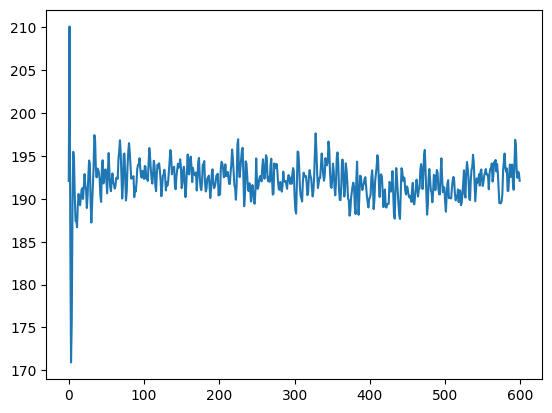

In [23]:
plt.plot(rg2)
plt.show()

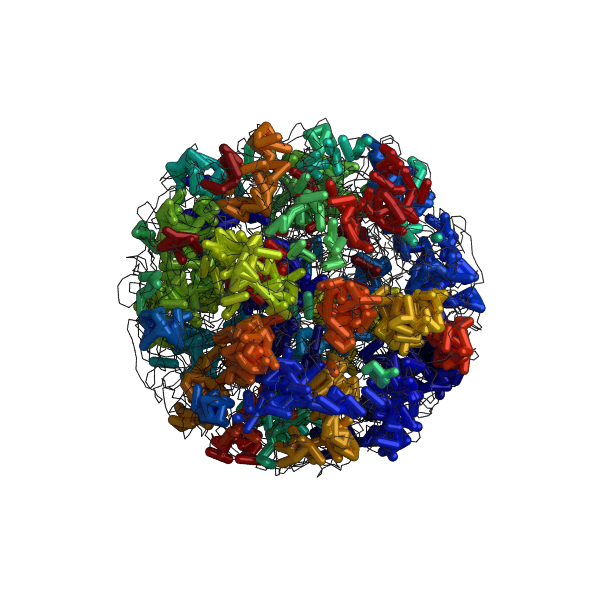

In [24]:
# Visualize new extrusion bonds 
render.fresnel(snap, show_loops=False, rescale_backbone_bonds=0.1, cmap="jet").static()

In [18]:
np.save("./hoomd_model_round1.npy", positions)

### Modelling from starting conformation:

In [37]:
iteration = 3

positions1 = np.load(f"./starting_model_round{iteration}.npy")

contacts = np.array(pd.read_csv(f"edges_round{iteration}.csv", index_col=0))[:, :2]
chrom_sizes = list(pd.read_csv(f"chrom-sizes_round{iteration}.csv").length)

In [38]:
# positions1 = np.load("/home/baneckik/sc-polychrom/hoomd_model_round0.npy")

# contacts = np.array(pd.read_csv("edges_round0.csv", index_col=0))[:, :2]
# chrom_sizes = list(pd.read_csv("chrom-sizes.csv").length)

In [39]:
len( contacts )

7624

In [40]:
sum(chrom_sizes)

61940

In [41]:
contacts[:5]

array([[    8,    64],
       [   10,    22],
       [30989, 32885],
       [   36,   699],
       [31010, 33055]])

In [56]:
start_time = time.time()
snap = simulate(number_of_iterations=6e5,
                chromosome_sizes=chrom_sizes, 
                dpd=True, 
                contact_list=contacts, 
                spherical=True, 
                starting_conformation=positions1
               )
end_time = time.time()
print(f"Computations time: {end_time-start_time}s")

In [43]:
trajectory = gsd.hoomd.open('trajectory.gsd', 'r')
rg2 = np.zeros(len(trajectory))

for i, snap in enumerate(trajectory):
    positions = unwrap_coordinates(snap)
    rg2[i] = polymer_analyses.Rg2(positions)

INFO:gsd.fl:opening file: trajectory.gsd with mode: r
INFO:gsd.hoomd:opening HOOMDTrajectory: <gsd.fl.GSDFile object at 0x55f371197750>
INFO:gsd.hoomd:found 600 frames
INFO:gsd.fl:closing file: trajectory.gsd


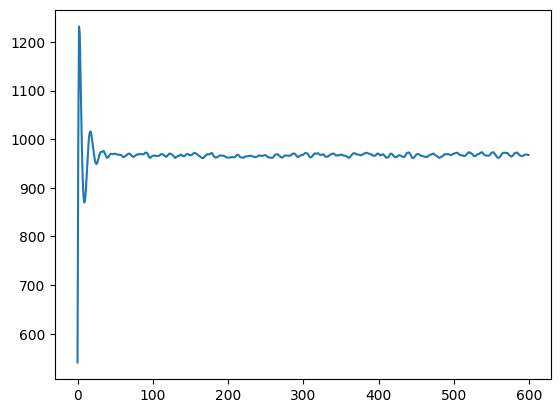

In [44]:
plt.plot(rg2)
plt.show()

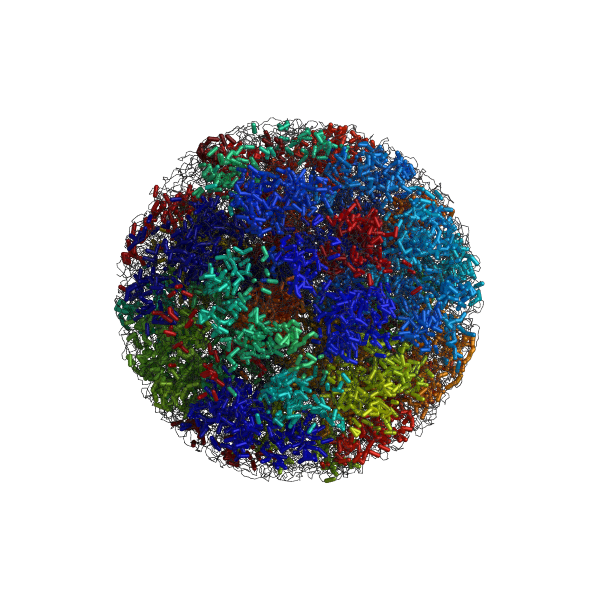

In [45]:
# Visualize new extrusion bonds 
render.fresnel(snap, show_loops=False, rescale_backbone_bonds=0.1, cmap="jet").static()

In [46]:
np.save(f"./hoomd_model_round{iteration}.npy", positions)

### Store scHi-C as a contact map

In [49]:
out_file = 'trajectory.gsd'

In [50]:
from polykit.analysis import contact_maps
import gsd

def load_gsd(filename):
    fname, group = filename.split("::")

    with gsd.hoomd.open(name=fname, mode="rb") as traj:
        return traj[int(group)].particles.position

skip = 100
trajectory = gsd.hoomd.open(name=out_file, mode="r")

URIs = [out_file + "::%d" % i for i in range(skip, len(list(trajectory)), 1)]


INFO:gsd.fl:opening file: trajectory.gsd with mode: r
INFO:gsd.hoomd:opening HOOMDTrajectory: <gsd.fl.GSDFile object at 0x55f36a5d9a80>
INFO:gsd.hoomd:found 600 frames
INFO:gsd.fl:closing file: trajectory.gsd


In [57]:
start = np.arange(1) * sum(chrom_sizes)
matrix = contact_maps.monomerResolutionContactMapSubchains(
                URIs,
                load_gsd,
                start,
                20000,
                cutoff=2.3,
                n=4)

In [59]:
clr = contact_maps.coolify(matrix, 'single_conformation')

In [78]:
from matplotlib.colors import LogNorm
norm = LogNorm(vmax=50)

/tmp/ipykernel_2398288/2144398400.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap("hot")


Text(0.5, 1.0, 'Contact map of a single conformation, single chromosome')

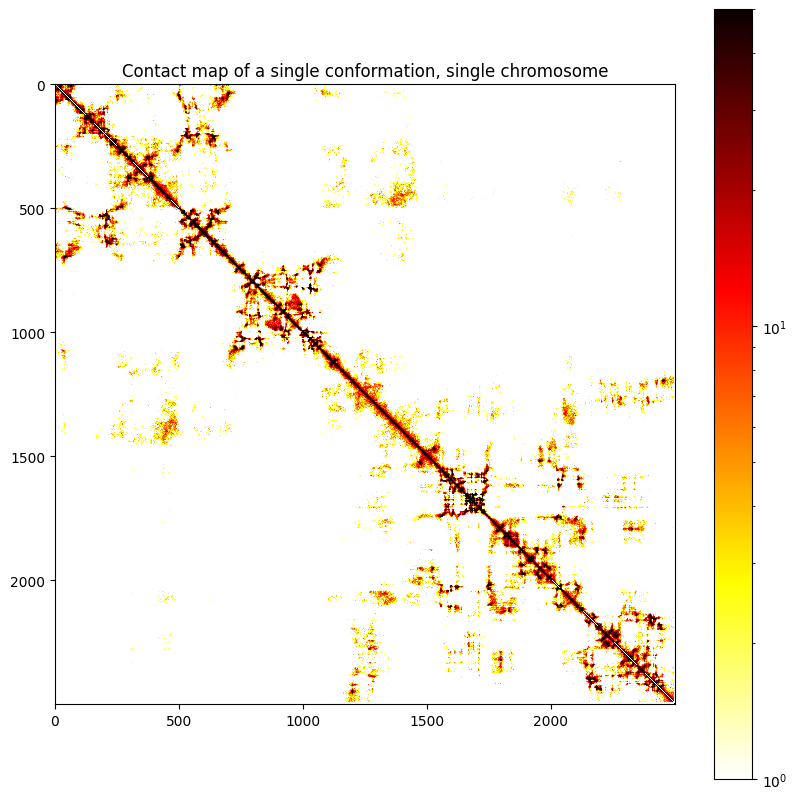

In [80]:
orig_map=plt.cm.get_cmap("hot") 
reversed_map = orig_map.reversed() 

plt.figure(figsize=(10,10))

plt.imshow(matrix[0:2500, 0:2500], norm=norm, interpolation="none", cmap=reversed_map)

plt.colorbar()
plt.title('Contact map of a single conformation, single chromosome')

In [ ]:
orig_map=plt.cm.get_cmap("hot") 
reversed_map = orig_map.reversed() 

plt.figure(figsize=(10,10))

plt.imshow(matrix, norm=norm, interpolation="none", cmap=reversed_map)

plt.colorbar()
plt.title('Contact map of a single conformation, whole genome')

/tmp/ipykernel_2398288/3220030311.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap("hot")
